In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith>=0.2.0 langchain-community langchain-core networkx langchain_experimental gradio
!pip install langchain-openai python-dotenv scikit-learn pandas langchain_mistralai beautifulsoup4 streamlit langchain_openai pyngrok

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 63.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 85.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4


In [3]:
from openai import OpenAI
from typing import List
import os
import getpass
import tempfile
import torch
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain 
import transformers
import pandas as pd
import numpy as np
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
import nest_asyncio
import pprint
from langchain_community.graphs.index_creator import GraphIndexCreator
from langchain.chains import GraphQAChain
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import SVG
from langchain_core.tools import StructuredTool
import json
import pyngrok
import streamlit as st
import gradio as gr
import sqlite3
import datetime
import uuid

In [4]:
# if not os.environ.get('MISTRAL_API_KEY'):
#      os.environ['MISTRAL_API_KEY'] = getpass.getpass('Mistral API Key')

# os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
if not os.environ.get('LANGSMITH_KEY'):
    os.environ['LANGSMITH_KEY'] = getpass.getpass('Enter LANGSMITH Key')

# if not os.environ.get('TAVILY_KEY'):
#     os.environ['TAVILY_KEY'] = getpass.getpass('Enter TAVILY Key')

if not os.environ.get('OPENAI_API_KEY'):
    os.environ['OPENAI_API_KEY'] = getpass.getpass('Enter OPENAI Key')
# os.environ['OPENAI_API_KEY'] = getpass.getpass('Enter OPENAI Key')

Enter LANGSMITH Key ········
Enter OPENAI Key ········


In [5]:
# Building a graph

network_graph = nx.MultiGraph()
network_graph.add_node("Hyderabad")
network_graph.add_node("Bangalore")
network_graph.add_node("Chennai")
network_graph.add_node("Amaravati")
network_graph.add_node("Delhi")

network_graph.add_edges_from([("Hyderabad", "Bangalore", {'distance' : 100, 'max_bandwidth' : 60, 'available_bandwidth' : 60, 'jitter' : 2, 'latency' : 6})])
network_graph.add_edges_from([("Hyderabad", "Bangalore", {'max_bandwidth' : 70, 'available_bandwidth' : 70, 'latency' : 7})])


network_graph.add_edges_from([("Hyderabad", "Delhi", {'distance' : 120, 'max_bandwidth' : 120, 'available_bandwidth' : 120, 'jitter' : 3, 'latency' : 12})])


network_graph.add_edges_from([("Hyderabad", "Amaravati", {'distance' : 50, 'max_bandwidth' : 50, 'available_bandwidth' : 50, 'jitter' : 1, 'latency' : 5})])
network_graph.add_edges_from([("Hyderabad", "Amaravati", {'max_bandwidth' : 70, 'available_bandwidth' : 70, 'latency' : 7})])
network_graph.add_edges_from([("Hyderabad", "Amaravati", {'max_bandwidth' : 60, 'available_bandwidth' : 60, 'latency' : 6})])


network_graph.add_edges_from([("Bangalore", "Chennai", {'distance' : 120, 'max_bandwidth' : 120, 'available_bandwidth' : 120, 'jitter' : 3, 'latency' : 12})])


network_graph.add_edges_from([("Bangalore", "Delhi", {'distance' : 10, 'max_bandwidth' : 50, 'available_bandwidth' : 50, 'jitter' : 1, 'latency' : 5})])
network_graph.add_edges_from([("Bangalore", "Delhi", {'max_bandwidth' : 70, 'available_bandwidth' : 70, 'latency' : 7})])
network_graph.add_edges_from([("Bangalore", "Delhi", {'max_bandwidth' : 60, 'available_bandwidth' : 60, 'latency' : 6})])


network_graph.add_edges_from([("Bangalore", "Amaravati", {'distance' : 30, 'max_bandwidth' : 50, 'available_bandwidth' : 50, 'jitter' : 1, 'latency' : 5})])
network_graph.add_edges_from([("Bangalore", "Amaravati", {'max_bandwidth' : 70, 'available_bandwidth' : 70, 'latency' : 7})])
network_graph.add_edges_from([("Bangalore", "Amaravati", {'max_bandwidth' : 60, 'available_bandwidth' : 60, 'latency' : 6})])


network_graph.add_edges_from([("Amaravati", "Delhi", {'distance' : 60, 'max_bandwidth' : 60, 'available_bandwidth' : 60, 'jitter' : 2, 'latency' : 6})])
network_graph.add_edges_from([("Amaravati", "Delhi", {'max_bandwidth' : 70, 'available_bandwidth' : 70, 'latency' : 7})])


network_graph.add_edges_from([("Chennai", "Delhi", {'distance' : 80, 'max_bandwidth' : 70, 'available_bandwidth' : 70, 'jitter' : 2, 'latency' : 7})])
network_graph.add_edges_from([("Chennai", "Delhi", {'max_bandwidth' : 80, 'available_bandwidth' : 80, 'latency' : 8})])

[1]

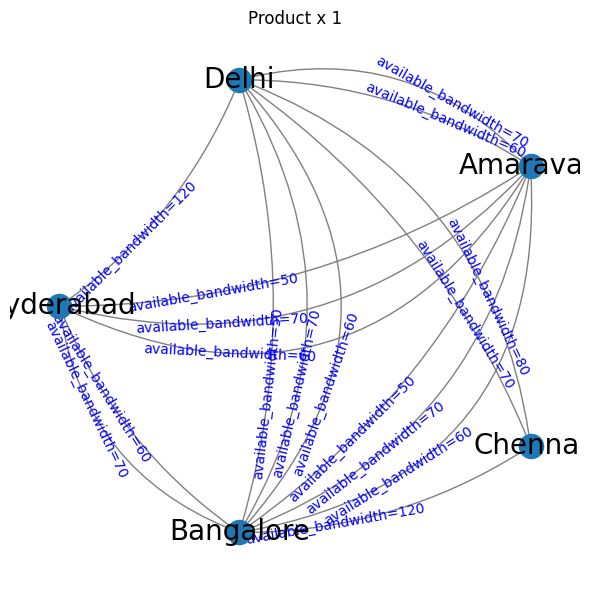

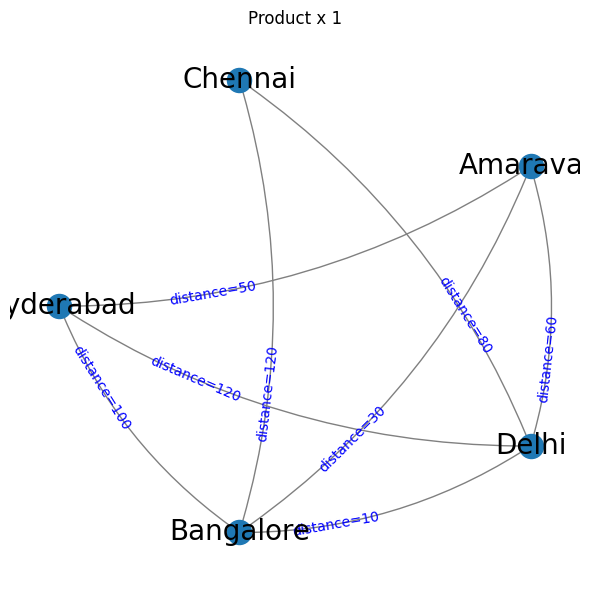

In [6]:
import itertools as it
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def draw_labeled_multigraph(network_graph, attr_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(network_graph)
    # pos = nx.spring_layout(network_graph)
    nx.draw_networkx_nodes(network_graph, pos, ax=ax)
    nx.draw_networkx_labels(network_graph, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        network_graph, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attr_name}={attrs[attr_name]}"
        for *edge, attrs in network_graph.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        network_graph,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )
    if ax is not None:  # Check if ax is provided
        for spine in ax.spines.values():
            spine.set_visible(False)



prod = list(it.product(network_graph.nodes, repeat=2))
pair_dict = {f"Product x {i}": prod * i for i in range(1, 2)}
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

for (name, pairs), ax in zip(pair_dict.items(), np.ravel(axes)):
    draw_labeled_multigraph(network_graph, "available_bandwidth", ax)
    ax.set_title(name)
fig.tight_layout()
plt.show()

distance_graph = nx.MultiGraph()
for i in network_graph.edges:
    if(i[2] == 0):
        a_node = i[0]
        z_node = i[1]
        # print(a_node, z_node)
        # print(G[a_node][z_node][i[2]]['distance'])
        distance_graph.add_nodes_from([a_node,z_node])
        distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
        
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
for (name, pairs), ax in zip(pair_dict.items(), np.ravel(axes)):
    draw_labeled_multigraph(distance_graph, "distance", ax)
    ax.set_title(name)
fig.tight_layout()
plt.show()

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [8]:
def get_shortest_path(network_graph, source_name:str, destination_name:str):
    """
    Calculates the shortest path between two nodes in a graph.

    This function utilizes the `networkx.shortest_path` function to find the
    shortest path between a source node and a destination node within a given graph.

    :param network_graph: The graph to work with in. This should be a NetworkX graph object.
    :type network_graph: networkx.Graph

    :param source_name: The name of the source node from which the shortest path begins.
    :type source_name: str

    :param destination_name: The name of the destination node where the shortest path ends.
    :type destination_name: str

    :raises NetworkXNoPath: If there is no path between the source and destination nodes.
    :raises NodeNotFound: If either the source or destination node is not found in the graph.

    :returns: A list of node names representing the nodes in the shortest path,
              starting from the source node and ending at the destination node.
    :rtype: List[str]
    """
    distance_graph = nx.MultiGraph()
    for i in network_graph.edges:
        if(i[2] == 0):
            a_node = i[0]
            z_node = i[1]
            distance_graph.add_nodes_from([a_node,z_node])
            distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
    
    return f"The shortest path between {source_name} and {destination_name} is {nx.shortest_path(distance_graph, source_name, destination_name, weight = 'distance')}"


async def aget_shortest_path(network_graph, source_name, destination_name):
    """
    Calculates the shortest path between two nodes in a graph.

    This function utilizes the `networkx.shortest_path` function to find the
    shortest path between a source node and a destination node within a given graph.

    :param network_graph: The graph to work with. This should be a NetworkX graph object.
    :type network_graph: networkx.Graph

    :param source_name: The name of the source node from which the shortest path begins.
    :type source_name: str

    :param destination_name: The name of the destination node where the shortest path ends.
    :type destination_name: str

    :raises NetworkXNoPath: If there is no path between the source and destination nodes.
    :raises NodeNotFound: If either the source or destination node is not found in the graph.

    :returns: A list of node names representing the nodes in the shortest path,
              starting from the source node and ending at the destination node.
    :rtype: List[str]
    """
    distance_graph = nx.MultiGraph()
    for i in network_graph.edges:
        if(i[2] == 0):
            a_node = i[0]
            z_node = i[1]
            distance_graph.add_nodes_from([a_node,z_node])
            distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
    return f"The shortest path between {source_name} and {destination_name} is {nx.shortest_path(distance_graph, source_name, destination_name, weight = 'distance')}"
    


get_shortest_path = StructuredTool.from_function(func=get_shortest_path, coroutine=aget_shortest_path)

In [9]:
def get_path_distance(network_graph, path_nodes_list:List):
    """
    Calculates the total distance of a path in a graph, given a list of nodes that define the path.

    :param network_graph: The graph to work with. This should be a NetworkX graph object.
    :type network_graph: networkx.Graph

    :param path_nodes_list: List of nodes for which the path distance needs to be calculated.
    :type List (A Python list)

    :raises NetworkXNoPath: If there is no path between the source and destination nodes.
    :raises NodeNotFound: If either the source or destination node is not found in the graph.

    :returns: The total calculated distance
    :rtype: int (A whole number).
    """
    distance_graph = nx.MultiGraph()
    for i in network_graph.edges:
        if(i[2] == 0):
            a_node = i[0]
            z_node = i[1]
            distance_graph.add_nodes_from([a_node,z_node])
            distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
            
    distance = 0
    for i in range(len(path_nodes_list)-1):
        distance += distance_graph[path_nodes_list[i]][path_nodes_list[i+1]][0]['distance']
    return f"The distance of the path {path_nodes_list} is {distance}"


async def aget_path_distance(network_graph, path_nodes_list:List):
    """
    Calculates the total distance of a path in a graph, given a list of nodes that define the path.

    :param network_graph: The graph to work with. This should be a NetworkX graph object.
    :type network_graph: networkx.Graph

    :param path_nodes_list: List of nodes for which the path distance needs to be calculated.
    :type List (A Python list)

    :raises NetworkXNoPath: If there is no path between the source and destination nodes.
    :raises NodeNotFound: If either the source or destination node is not found in the graph.

    :returns: The total calculated distance
    :rtype: int (A whole number).
    """

    distance_graph = nx.MultiGraph()
    for i in network_graph.edges:
        if(i[2] == 0):
            a_node = i[0]
            z_node = i[1]
            distance_graph.add_nodes_from([a_node,z_node])
            distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
            
    distance = 0
    for i in range(len(path_nodes_list)-1):
        distance += distance_graph[path_nodes_list[i]][path_nodes_list[i+1]][0]['distance']
    return f"The distance of the path {path_nodes_list} is {distance}"


get_path_distance = StructuredTool.from_function(func=get_path_distance, coroutine=aget_path_distance)

In [10]:
def find_all_simple_paths(network_graph, source_name:str, destination_name:str):
    """
    Returns all simple paths from source to destination in the given network graph.

    :param network_graph: The graph to work with. This should be a NetworkX graph object.
    :type network_graph: networkx.Graph

    :param source_name: The name of the source node from which the shortest path begins.
    :type source_name: str

    :param destination_name: The name of the destination node where the shortest path ends.
    :type destination_name: str

    :returns: list of all simple paths from source to destination
    :rtype: List
    """
    distance_graph = nx.MultiGraph()
    for i in network_graph.edges:
        if(i[2] == 0):
            a_node = i[0]
            z_node = i[1]
            distance_graph.add_nodes_from([a_node,z_node])
            distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
            
    all_simple_paths = [path for path in nx.all_simple_paths(distance_graph, source=source_name, target=destination_name)]
        
    return f"All simple paths between {source_name} and {destination_name} are {all_simple_paths}"


async def afind_all_simple_paths(network_graph, source_name:str, destination_name:str):
    """
    Returns all simple paths from source to destination in the given network graph.

    :param network_graph: The graph to work with. This should be a NetworkX graph object.
    :type network_graph: networkx.Graph

    :param source_name: The name of the source node from which the shortest path begins.
    :type source_name: str

    :param destination_name: The name of the destination node where the shortest path ends.
    :type destination_name: str

    :returns: list of all simple paths from source to destination
    :rtype: List
    """
    distance_graph = nx.MultiGraph()
    for i in network_graph.edges:
        if(i[2] == 0):
            a_node = i[0]
            z_node = i[1]
            distance_graph.add_nodes_from([a_node,z_node])
            distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
            
    all_simple_paths = [path for path in nx.all_simple_paths(distance_graph, source=source_name, target=destination_name)]
        
    return f"All simple paths between {source_name} and {destination_name} are {all_simple_paths}"


find_all_simple_paths = StructuredTool.from_function(func=find_all_simple_paths, coroutine=afind_all_simple_paths)

In [11]:
def check_paths_feasibility(network_graph, all_simple_paths, requested_bandwidth, requested_latency, requested_jitter):
    """
    Given a full graph's adjacency matrix and a path to check for feasibility, 
    the function returns the feasible path if the path is feasible otherwise returns False.

    :param network_graph: The graph to work with. This should be a NetworkX graph object.
    :type network_graph: networkx.Graph

    :param all_simple_paths: The list of paths from source node to the destination node.
    :rtype: List

    :param requested_bandwidth: The requested amount of bandwidth.
    :rtype: int

    :param requested_latency: The requested Latency.
    :rtype: int

    :param requested_jitter: The requested Jitter.
    :rtype: int

    :returns: list of all simple paths from source to destination that are feasible
    :rtype: List(List)
    """
    network_graph_adjacency_matrix = network_graph.adj
    feasible_paths = []
    for path in all_simple_paths:
        path_feasibility = []
        for i in range(len(path)-1):
            links_feasibility = []
            for j in range(len(network_graph_adjacency_matrix[path[i]][path[i+1]])):
                if(network_graph_adjacency_matrix[path[i]][path[i+1]][j]['available_bandwidth'] < requested_bandwidth or 
                  network_graph_adjacency_matrix[path[i]][path[i+1]][j]['latency'] < requested_latency or
                  network_graph_adjacency_matrix[path[i]][path[i+1]][0]['jitter'] < requested_jitter):
                    links_feasibility.append(False)
                else:
                    links_feasibility.append(True)
            if(all(links_feasibility)):
                path_feasibility.append(True)
            else:
                path_feasibility.append(False)
        if(all(path_feasibility)):
            feasible_paths.append(path)
                
    return f"All feasible paths among all simple paths with bandwith {requested_bandwidth}, latency {requested_latency}, and jitter {requested_jitter} are {feasible_paths}."


async def acheck_paths_feasibility(network_graph, all_simple_paths, requested_bandwidth, requested_latency, requested_jitter):
    """
    Given a full graph's adjacency matrix and a path to check for feasibility, 
    the function returns the feasible path if the path is feasible otherwise returns False.

    :param network_graph: The graph to work with. This should be a NetworkX graph object.
    :type network_graph: networkx.Graph

    :param all_simple_paths: The list of paths from source node to the destination node.
    :rtype: List

    :param requested_bandwidth: The requested amount of bandwidth.
    :rtype: int

    :param requested_latency: The requested Latency.
    :rtype: int

    :param requested_jitter: The requested Jitter.
    :rtype: int

    :returns: list of all simple paths from source to destination that are feasible
    :rtype: List(List)
    """
    network_graph_adjacency_matrix = network_graph.adj
    feasible_paths = []
    for path in all_simple_paths:
        path_feasibility = []
        for i in range(len(path)-1):
            links_feasibility = []
            for j in range(len(network_graph_adjacency_matrix[path[i]][path[i+1]])):
                if(network_graph_adjacency_matrix[path[i]][path[i+1]][j]['available_bandwidth'] < requested_bandwidth or 
                  network_graph_adjacency_matrix[path[i]][path[i+1]][j]['latency'] < requested_latency or
                  network_graph_adjacency_matrix[path[i]][path[i+1]][0]['jitter'] < requested_jitter):
                    links_feasibility.append(False)
                else:
                    links_feasibility.append(True)
            if(all(links_feasibility)):
                path_feasibility.append(True)
            else:
                path_feasibility.append(False)
        if(all(path_feasibility)):
            feasible_paths.append(path)
                
    return f"All feasible paths among all simple paths with bandwith {requested_bandwidth}, latency {requested_latency}, and jitter {requested_jitter} are {feasible_paths}."



check_paths_feasibility = StructuredTool.from_function(func=check_paths_feasibility, coroutine=acheck_paths_feasibility)

In [12]:
def get_permission_for_resource_allocation():
    """
    The tool gets users' permission whether to allocate resources or not.

    :returns: Yes or No
    :rtype: Boolean
    """
    print(f"\nYour input is required for the resource allocation")
    human_response = input("Please enter 'yes' or 'no': ").strip().lower()
    while human_response not in ['yes', 'no']:
        print("Invalid input. Please enter 'yes' or 'no'.")
        human_response = input("Please enter 'yes' or 'no': ").strip().lower()
        
                
    return f"The users' response is {human_response}."


async def aget_permission_for_resource_allocation():
    """
    The tool gets users' permission whether to allocate resources or not.

    :returns: Yes or No
    :rtype: Boolean
    """
    print(f"\nYour input is required for the resource allocation ")
    human_response = input("Please enter 'yes' or 'no': ").strip().lower()
    while human_response not in ['yes', 'no']:
        print("Invalid input. Please enter 'yes' or 'no'.")
        human_response = input("Please enter 'yes' or 'no': ").strip().lower()
        
                
    return f"The users' response is {human_response}."



get_permission_for_resource_allocation = StructuredTool.from_function(func=get_permission_for_resource_allocation, coroutine=aget_permission_for_resource_allocation)

In [13]:
def allocate_resources(network_graph, best_feasible_path, requested_bandwidth, requested_latency, requested_jitter):
    """
    Given the network_graph, best feasible path(less path distance), requested_bandwidth, requested_latency, requested_jitter
    the function allocates resources in first fit manner. The function makes necessary modifications in the network graph and 
    returns the network graph's adjacency matrix, which has to be used later for other activities.

    :param network_graph: The graph to work with. This should be a NetworkX graph object.
    :type network_graph: networkx.Graph

    :param best_feasible_path: Best feasible path from source node to the destination node.
    :rtype: List

    :param requested_bandwidth: The requested amount of bandwidth.
    :rtype: int

    :param requested_latency: The requested Latency.
    :rtype: int

    :param requested_jitter: The requested Jitter.
    :rtype: int

    :returns: network_graph, NetworkX graph object
    :rtype: networkx.Graph
    """
    network_graph_adjacency_matrix =  network_graph.adj
    all_chosen_links = []
    for i in range(len(best_feasible_path)-1):
        for k in range(len(network_graph_adjacency_matrix[best_feasible_path[i]][best_feasible_path[i+1]])):
            if(network_graph_adjacency_matrix[best_feasible_path[i]][best_feasible_path[i+1]][k]['available_bandwidth'] >= requested_bandwidth and \
               network_graph_adjacency_matrix[best_feasible_path[i]][best_feasible_path[i+1]][k]['latency'] >= requested_latency and \
               network_graph_adjacency_matrix[best_feasible_path[i]][best_feasible_path[i+1]][k]['jitter'] >= requested_jitter):
                all_chosen_links.append((best_feasible_path[i], best_feasible_path[i+1], k))
                break

    for i in all_chosen_links:
        network_graph.edges[i]['available_bandwidth'] -= requested_bandwidth
                
    return network_graph


async def aallocate_resources(network_graph, best_feasible_path, requested_bandwidth, requested_latency, requested_jitter):
    """
    Given the network_graph, best feasible path(less path distance), requested_bandwidth, requested_latency, requested_jitter
    the function allocates resources in first fit manner. The function makes necessary modifications in the network graph and 
    returns the network graph's adjacency matrix, which has to be used later for other activities.

    :param network_graph: The graph to work with. This should be a NetworkX graph object.
    :type network_graph: networkx.Graph

    :param best_feasible_path: Best feasible path from source node to the destination node.
    :rtype: List

    :param requested_bandwidth: The requested amount of bandwidth.
    :rtype: int

    :param requested_latency: The requested Latency.
    :rtype: int

    :param requested_jitter: The requested Jitter.
    :rtype: int

    :returns: network_graph, NetworkX graph object
    :rtype: networkx.Graph
    """
    network_graph_adjacency_matrix =  network_graph.adj
    all_chosen_links = []
    for i in range(len(best_feasible_path)-1):
        for k in range(len(network_graph_adjacency_matrix[best_feasible_path[i]][best_feasible_path[i+1]])):
            if(network_graph_adjacency_matrix[best_feasible_path[i]][best_feasible_path[i+1]][k]['available_bandwidth'] >= requested_bandwidth and \
               network_graph_adjacency_matrix[best_feasible_path[i]][best_feasible_path[i+1]][k]['latency'] >= requested_latency and \
               network_graph_adjacency_matrix[best_feasible_path[i]][best_feasible_path[i+1]][k]['jitter'] >= requested_jitter):
                all_chosen_links.append((best_feasible_path[i], best_feasible_path[i+1], k))
                break

    for i in all_chosen_links:
        network_graph.edges[i]['available_bandwidth'] -= requested_bandwidth
    
                
    return network_graph



allocate_resources = StructuredTool.from_function(func=allocate_resources, coroutine=aallocate_resources)

In [14]:
print(type(get_shortest_path))
print(type(get_path_distance))
print(type(find_all_simple_paths))
print(type(check_paths_feasibility))
print(type(allocate_resources))
print(type(get_permission_for_resource_allocation))

<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.tools.structured.StructuredTool'>


In [15]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]


class Agent:
    def __init__(self, llm, tools, network_graph, system):
        self.system = system
        self.network_graph = network_graph
        self.conn = self.create_db()
        agent = StateGraph(AgentState)
        agent.add_node("llm", self.call_openai)
        agent.add_node("action", self.take_action)
        agent.add_conditional_edges("llm", self.exists_action)
        agent.add_edge("action", "llm")
        agent.set_entry_point("llm")
        self.agent = agent.compile()
        self.tools = {t.name: t for t in tools}
        self.llm = llm.bind_tools(tools)

    def create_db(self):
        conn = sqlite3.connect('resource_graph.db')
        cursor = conn.cursor()

        cursor.execute(
            '''
            CREATE TABLE allocations (
            allocation_id TEXT PRIMARY KEY,
            user_id TEXT,
            source_node TEXT,
            destination_node TEXT,
            bandwidth REAL,
            latency INTEGER,
            jitter INTEGER,
            allocation_timestamp TEXT,
            status TEXT,
            notes TEXT)
            '''
        )
        
        cursor.execute(
            '''
            CREATE TABLE allocation_paths (
            path_id INTEGER PRIMARY KEY AUTOINCREMENT,
            allocation_id TEXT,
            edge_order INTEGER,
            source_node TEXT,
            destination_node TEXT,
            edge_key TEXT,
            FOREIGN KEY (allocation_id) REFERENCES allocations(allocation_id))
            '''
        )
        
        cursor.execute(''' CREATE INDEX idx_alloc_user_id ON allocations (user_id);''')
        cursor.execute('''CREATE INDEX idx_alloc_source_node ON allocations (source_node);''')
        cursor.execute('''CREATE INDEX idx_alloc_destination_node ON allocations (destination_node);''')
        cursor.execute('''CREATE INDEX idx_alloc_status ON allocations (status);''')
        cursor.execute('''CREATE INDEX idx_alloc_timestamp ON allocations (allocation_timestamp);''')
        cursor.execute('''CREATE INDEX idx_path_allocation_id ON allocation_paths (allocation_id)''')
        print('Database Created')
        return conn

    def call_openai(self, state:AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.llm.invoke(messages)
        return {'messages': [message]}
        

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        if(len(result.tool_calls)) > 0:
            return 'action'
        else:
            return END
        # return len(result.tool_calls) > 0

    def take_action(self, state:AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"\n\nCalling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                tool_result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                print(t, t['args'], type(t['args']))
                # result = self.tools[t['name']].invoke(t['args'])
                tool_result = self.tools[t['name']].invoke({
                    "network_graph": self.network_graph,  # Pass the actual graph object here
                    "source_name": t['args'].get("source_name"), # Extract source_name from LLM args
                    "destination_name": t['args'].get("destination_name"), # Extract destination_name from LLM args
                    "path_nodes_list": t['args'].get("path_nodes_list"), # Extract path_nodes_list from LLM args
                    "network_graph_adjacency_matrix": self.network_graph.adj, # t['args'].get("network_graph_adjacency_matrix"),
                    "requested_bandwidth": t['args'].get("requested_bandwidth"),
                    "requested_latency": t['args'].get("requested_latency"),
                    "requested_jitter": t['args'].get("requested_jitter"),
                    "all_simple_paths":t['args'].get("all_simple_paths"),
                    "best_feasible_path":t['args'].get("best_feasible_path")
                })
            
                # print('Intermediate Result :', result)
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(tool_result)))
        print("Back to the model!")
        return {'messages': results}

In [17]:
prompt = """

**Your Goal:**  - To answer user queries related to graph analysis on a given network graph, such as:
			Edge existence, edge distance, path feasibility etc.,
                        OR
            	- Allocate resources if the user asks, if the they are available.

            	**Pay close attention to the user's query and answer exactly what is asked, nothing more, nothing less.**
            	IMPORTANT: DONOT ALLOCATE RESOURCES WITHOUT TAKING USERS PERMISSION.
            

**Your Process:**
0. 
    a. You are are given a "network graph", which is a multigraph, with 
        i: edge properties: 
                distance, 
                max_bandwidth, 
                available_bandwith, 
                jitter, and 
                latency.
        ii: Nodes are city names.
    b. You are also given network graph's adjacency matrix in a dictionary format.
    
1. **Query Analysis & Type Identification:** Carefully examine the user's query. Determine the *type* of query based on keywords and the question asked:

    * **Type 1a: Shortest Path Query:** If the query asks for the *shortest*, *quickest*, or *fastest* path between two specific locations (nodes).
        * **Keywords:** "shortest," "quickest," "fastest", "shortest way," "quickest way," "fastest way," "path from...to...", "way to get from...to...".
        * **Identify:** Source Name, Destination Name.
        * **Example Queries:** "What is the shortest path...", "Quickest way to get...", "Fastest route from..."
	* ** Human Response: ** Not required.

    * **Type 1b: All Simple Paths Query:** If the query asks for *all simple paths* between two specific locations.
        * **Keywords:** "all paths," "all simple paths," "all ways," "list all paths," "find all paths". 
        * **Identify:** Source Name, Destination Name.
        * **Example Queries:** "What are all simple paths...", "List all paths from...to...", "Find all ways to get from...to..."
	* ** Human Response: ** Not required.

    * **Type 1c: Adjacency Matrix Query:** If the query is *not* asking for paths between two locations (doesn't fit Type 1a or 1b criteria), assume it's a general graph query answerable by the adjacency matrix. Feasibility is not relevant for this type.
        * **Keywords:** "connections," "connected," "neighbors," "adjacent," "matrix," "graph information," "relationships".
        * **Example Queries:** "Tell me about the connections...", "Is node A connected to node B?", "What is the adjacency matrix...", "Graph information..."
	* ** Human Response: ** Not required.
    
    * **Type 1d: Feasibility Check Query:** If the query is asking for availability of a path from a source to destination with specific bandwidth, latency, and jitter.
        * **Keywords:** "feasible," "feasibility," "available," "availability,".
        * **Example Queries:** "IS THERE a path with bandwidth between ", "IS THERE a feasible path with bandwidth, jitter, and latency between", "WHAT is the BEST POSSIBLE path with bandwidth, jitter, and latency between", "CAN resources be allocated between source and destination with bandwidth, jitter, and latency between".
	* ** Human Response: ** Not required.

    * **Type 2: Allocate Resources:** If the query is asking for resource allocation from a source to destination with specific bandwidth, latency, and jitter.
        * **Keywords:** "allocate," "assign," "reserve," "book,".
        * **Example Queries:** "ALLOCATE a path with bandwidth between ", "ASSIGN a feasible path with bandwidth, jitter, and latency between", "RESERVE best possible path with bandwidth, jitter, and latency between".
	* ** Human Response: ** Required **.

    ** Always use right number of arguments and also right type of arguments for each tool call **        
        
        
    **Important:**  After analyzing the query,
                    **Explicitly determine if it's Type 1a, Type 1b, Type 1c, Type 1d, or Type 2.**
                    **ANSWER ONLY WHAT THE QUERY TYPE DICTATES.**
                    **Do not provide shortest path information if the query is for all simple paths, and vice versa.**
                    **DO NOT USE EXTERNAL GRAPHS, USE ONLY THE GIVEN GRAPH.**
		    ** If the query is to allocate resources, then begin by finding with all simple paths **

2. **Tool Selection based on Query Type:**

    * **If Query Type is 1a (Shortest Path):** Use the **Shortest Path Tool**.
    * **If Query Type is 1b (All Simple Paths):** Use the **All Simple Paths Tool**.
    * **If Query Type is 1c (Adjacency Matrix):** Use the **Adjacency Matrix**.
    * **Multiple Calls Allowed (for Pathfinding Tools):** For Type 1a or 1b queries, you can use the respective pathfinding tool multiple times (max 5) if needed for complex queries. Distance calculations are performed after paths are found. The Adjacency Matrix Tool is typically used once per Type 2 query.

    * **If Query Type is 1d (Feasibility Check)**: For Type 1c queries, you have access to all the tools EXCEPT Allocate Resources.
        **From the user query, identify source name, destination name, required bandwidth, required jitter, required latency**
            ** Identify all simple paths from source to destination **
            ** Call check paths feasibility with all simple paths, requested bandwidth, latency, and jitter.
            ** Store all feasible paths that are feasibility**

    * **If Query Type is 2 (Allocate Resources)**: For Type 2 queries, you have access to all the tools.
        **From the user query, identify source name, destination name, required bandwidth, required jitter, required latency**
            ** network graph is an important part in the operations
            ** Identify all simple paths from source to destination **
            ** Call check paths feasibility with all simple paths, requested bandwidth, latency, and jitter.
            ** Store all feasible paths that are feasibility**
            ** Pick the path with less distance, which is called as best_feasible_path **
	    ** Ask the human whether to allocate resources for the best_feasible_path **
	    ** If the response is **YES** then continue with allocating resources, otherwise end the process.
            ** Use this best_feasible_path to allocate resources**
    * **There can also be mix : ** Few Queries might also require invoking multiple tools(Like feasibility check, all simple paths distances, and allocate resources)


3. **Answer Generation based on Query Type:**

    * **If Query Type was 1a (Shortest Path):** Present **ONLY** the shortest path (list of nodes) and its distance.
        * **Example Answer:** "The shortest path from [Source] to [Destination] is: [Shortest Path Nodes]. The distance is: [Shortest Path Distance]."

    * **If Query Type was 1b (All Simple Paths):** Present **ONLY** all simple paths (list of lists of nodes) and their corresponding distances. Clearly label each path and its distance.
        * **Example Answer:** "All simple paths from [Source] to [Destination] are:
          Path 1: [Path 1 Nodes], Distance: [Path 1 Distance]
          Path 2: [Path 2 Nodes], Distance: [Path 2 Distance]
          ... and so on."

    * **If Query Type was 1c (Adjacency Matrix):** Use the adjacency matrix to answer the query. Provide information relevant to the question based on the matrix.
        * **Example Answer:** "Based on the adjacency matrix, [Node A] is directly connected to [Node B] and [Node C]. [Node D] is not directly connected to [Node A]. [Further analysis based on the query]."

    * **If Query Type was 1d (Feasibility Check):** Present **ONLY** the feasible paths (list of nodes), If nothing is found then specify.
        * **Example Answer:** There are feasible paths from Hyderabad to Chennai with the specified requirements. The feasible paths are:

            1. Path: **Hyderabad -> Bangalore -> Chennai**
            2. Path: **Hyderabad -> Delhi -> Chennai** 

            Both paths meet the bandwidth, latency, and jitter requirements.

    * **If Query Type was 2 (Allocate Resources):** Present the **BEST** Feasible path, and say that the resources are allocated.
        * **Example Answer:** The requested resources are allocated between [Source node] and [Destination Node] along the [Path].
"""

In [18]:
abot = Agent(llm, [get_shortest_path, get_path_distance, find_all_simple_paths, check_paths_feasibility, allocate_resources, get_permission_for_resource_allocation], network_graph, system=prompt)

Database Created


In [189]:
# os.remove('/kaggle/working/resource_graph.db')

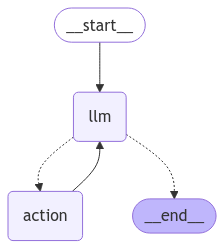

In [170]:
from IPython.display import Image

Image(abot.agent.get_graph().draw_mermaid_png())

In [171]:
messages = [HumanMessage(content="Is there a path from Hyderabad to Chennai with bandwidth 50, jitter 2, and latency 5?")]
result = abot.agent.invoke({"messages": messages})
print(result['messages'][-1].content)



Calling: {'name': 'find_all_simple_paths', 'args': {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_oCEcqNUdrgk9MQWEwrD1FeW1', 'type': 'tool_call'}
{'name': 'find_all_simple_paths', 'args': {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_oCEcqNUdrgk9MQWEwrD1FeW1', 'type': 'tool_call'} {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'} <class 'dict'>
Back to the model!


Calling: {'name': 'check_paths_feasibility', 'args': {'network_graph': 'network_graph', 'all_simple_paths': [['Hyderabad', 'Bangalore', 'Chennai'], ['Hyderabad', 'Bangalore', 'Delhi', 'Chennai'], ['Hyderabad', 'Bangalore', 'Amaravati', 'Delhi', 'Chennai'], ['Hyderabad', 'Delhi', 'Bangalore', 'Chennai'], ['Hyderabad', 'Delhi', 'Chennai'], ['Hyderabad', 'Delhi', 'Amaravati', 'Bangalore', 'Chennai'], ['Hyderabad', 'Amaravati', 'Bangalore', 'Chennai'], ['Hyderabad'

In [172]:
messages = [HumanMessage(content="In the given graph, what is direct edge distance between Hyd to del?")]
result = abot.agent.invoke({"messages": messages})
print(result['messages'][-1].content)



Calling: {'name': 'check_paths_feasibility', 'args': {'network_graph': {}, 'all_simple_paths': [], 'requested_bandwidth': 0, 'requested_latency': 0, 'requested_jitter': 0}, 'id': 'call_Ae3YsEnY4KzwuK6bxebpymRy', 'type': 'tool_call'}
{'name': 'check_paths_feasibility', 'args': {'network_graph': {}, 'all_simple_paths': [], 'requested_bandwidth': 0, 'requested_latency': 0, 'requested_jitter': 0}, 'id': 'call_Ae3YsEnY4KzwuK6bxebpymRy', 'type': 'tool_call'} {'network_graph': {}, 'all_simple_paths': [], 'requested_bandwidth': 0, 'requested_latency': 0, 'requested_jitter': 0} <class 'dict'>
Back to the model!
There is no direct edge distance between Hyderabad and Delhi in the given graph.


In [173]:
messages = [HumanMessage(content="In the given graph, what is direct edge distance between Hyderabad to Amaravati?")]
result = abot.agent.invoke({"messages": messages})
print(result['messages'][-1].content)



Calling: {'name': 'get_path_distance', 'args': {'network_graph': {}, 'path_nodes_list': ['Hyderabad', 'Amaravati']}, 'id': 'call_QzNtxCeTHQo8ysAAQoaDeVeb', 'type': 'tool_call'}
{'name': 'get_path_distance', 'args': {'network_graph': {}, 'path_nodes_list': ['Hyderabad', 'Amaravati']}, 'id': 'call_QzNtxCeTHQo8ysAAQoaDeVeb', 'type': 'tool_call'} {'network_graph': {}, 'path_nodes_list': ['Hyderabad', 'Amaravati']} <class 'dict'>
Back to the model!
The direct edge distance between Hyderabad and Amaravati is: 50.


In [174]:
messages = [HumanMessage(content="In the given graph, allocate resources from Hyderabad to Chennai with bandwidth 50, jitter 2, and latency 5?")]
result = abot.agent.invoke({"messages": messages})
print(result['messages'][-1].content)



Calling: {'name': 'find_all_simple_paths', 'args': {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_jcQOHMG8ZHR5VPt7GA79bow6', 'type': 'tool_call'}
{'name': 'find_all_simple_paths', 'args': {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_jcQOHMG8ZHR5VPt7GA79bow6', 'type': 'tool_call'} {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'} <class 'dict'>
Back to the model!


Calling: {'name': 'check_paths_feasibility', 'args': {'network_graph': 'network_graph', 'all_simple_paths': [['Hyderabad', 'Bangalore', 'Chennai'], ['Hyderabad', 'Bangalore', 'Delhi', 'Chennai'], ['Hyderabad', 'Bangalore', 'Amaravati', 'Delhi', 'Chennai'], ['Hyderabad', 'Delhi', 'Bangalore', 'Chennai'], ['Hyderabad', 'Delhi', 'Chennai'], ['Hyderabad', 'Delhi', 'Amaravati', 'Bangalore', 'Chennai'], ['Hyderabad', 'Amaravati', 'Bangalore', 'Chennai'], ['Hyderabad'

Please enter 'yes' or 'no':  no


Back to the model!
The requested resources cannot be allocated from Hyderabad to Chennai as the user has declined the request. If you need further assistance, feel free to ask!


In [176]:
abot.network_graph.adj

MultiAdjacencyView({'Hyderabad': {'Bangalore': {0: {'distance': 100, 'max_bandwidth': 60, 'available_bandwidth': 60, 'jitter': 2, 'latency': 6}, 1: {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}}, 'Delhi': {0: {'distance': 120, 'max_bandwidth': 120, 'available_bandwidth': 120, 'jitter': 3, 'latency': 12}}, 'Amaravati': {0: {'distance': 50, 'max_bandwidth': 50, 'available_bandwidth': 50, 'jitter': 1, 'latency': 5}, 1: {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}, 2: {'max_bandwidth': 60, 'available_bandwidth': 60, 'latency': 6}}}, 'Bangalore': {'Hyderabad': {0: {'distance': 100, 'max_bandwidth': 60, 'available_bandwidth': 60, 'jitter': 2, 'latency': 6}, 1: {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}}, 'Chennai': {0: {'distance': 120, 'max_bandwidth': 120, 'available_bandwidth': 120, 'jitter': 3, 'latency': 12}}, 'Delhi': {0: {'distance': 10, 'max_bandwidth': 50, 'available_bandwidth': 50, 'jitter': 1, 'latency': 5}, 1: {'max_bandwidth

In [177]:
messages = [HumanMessage(content="In the given graph, allocate resources from Hyderabad to Chennai with bandwidth 50, jitter 2, and latency 5?")]
result = abot.agent.invoke({"messages": messages})
print(result['messages'][-1].content)



Calling: {'name': 'find_all_simple_paths', 'args': {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_DCMo6PbeVxnl7Nf5mZ2vr1f8', 'type': 'tool_call'}
{'name': 'find_all_simple_paths', 'args': {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_DCMo6PbeVxnl7Nf5mZ2vr1f8', 'type': 'tool_call'} {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'} <class 'dict'>
Back to the model!


Calling: {'name': 'check_paths_feasibility', 'args': {'network_graph': 'network_graph', 'all_simple_paths': [['Hyderabad', 'Bangalore', 'Chennai'], ['Hyderabad', 'Bangalore', 'Delhi', 'Chennai'], ['Hyderabad', 'Bangalore', 'Amaravati', 'Delhi', 'Chennai'], ['Hyderabad', 'Delhi', 'Bangalore', 'Chennai'], ['Hyderabad', 'Delhi', 'Chennai'], ['Hyderabad', 'Delhi', 'Amaravati', 'Bangalore', 'Chennai'], ['Hyderabad', 'Amaravati', 'Bangalore', 'Chennai'], ['Hyderabad'

Please enter 'yes' or 'no':  yes


Back to the model!


Calling: {'name': 'allocate_resources', 'args': {'network_graph': 'network_graph', 'best_feasible_path': ['Hyderabad', 'Bangalore', 'Chennai'], 'requested_bandwidth': 50, 'requested_latency': 5, 'requested_jitter': 2}, 'id': 'call_qA6sAAz4Je9msE9qxpbUqkz6', 'type': 'tool_call'}
{'name': 'allocate_resources', 'args': {'network_graph': 'network_graph', 'best_feasible_path': ['Hyderabad', 'Bangalore', 'Chennai'], 'requested_bandwidth': 50, 'requested_latency': 5, 'requested_jitter': 2}, 'id': 'call_qA6sAAz4Je9msE9qxpbUqkz6', 'type': 'tool_call'} {'network_graph': 'network_graph', 'best_feasible_path': ['Hyderabad', 'Bangalore', 'Chennai'], 'requested_bandwidth': 50, 'requested_latency': 5, 'requested_jitter': 2} <class 'dict'>
Back to the model!
The requested resources are allocated between Hyderabad and Chennai along the path **Hyderabad -> Bangalore -> Chennai**.


In [178]:
abot.network_graph.adj

MultiAdjacencyView({'Hyderabad': {'Bangalore': {0: {'distance': 100, 'max_bandwidth': 60, 'available_bandwidth': 10, 'jitter': 2, 'latency': 6}, 1: {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}}, 'Delhi': {0: {'distance': 120, 'max_bandwidth': 120, 'available_bandwidth': 120, 'jitter': 3, 'latency': 12}}, 'Amaravati': {0: {'distance': 50, 'max_bandwidth': 50, 'available_bandwidth': 50, 'jitter': 1, 'latency': 5}, 1: {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}, 2: {'max_bandwidth': 60, 'available_bandwidth': 60, 'latency': 6}}}, 'Bangalore': {'Hyderabad': {0: {'distance': 100, 'max_bandwidth': 60, 'available_bandwidth': 10, 'jitter': 2, 'latency': 6}, 1: {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}}, 'Chennai': {0: {'distance': 120, 'max_bandwidth': 120, 'available_bandwidth': 70, 'jitter': 3, 'latency': 12}}, 'Delhi': {0: {'distance': 10, 'max_bandwidth': 50, 'available_bandwidth': 50, 'jitter': 1, 'latency': 5}, 1: {'max_bandwidth'

In [ ]:
conn = sqlite3.connect('resource_graph.db')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE allocations (
    allocation_id TEXT PRIMARY KEY,
    user_id TEXT,
    source_node TEXT,
    destination_node TEXT,
    bandwidth REAL,
    latency INTEGER,
    jitter INTEGER,
    allocation_timestamp TEXT,
    status TEXT,
    notes TEXT
)
''')

cursor.execute(
    '''
    CREATE TABLE allocation_paths (
    path_id INTEGER PRIMARY KEY AUTOINCREMENT,
    allocation_id TEXT,
    edge_order INTEGER,
    source_node TEXT,
    destination_node TEXT,
    edge_key TEXT,
    FOREIGN KEY (allocation_id) REFERENCES allocations(allocation_id)
)
    
    '''
)

cursor.execute(
    '''
    CREATE INDEX idx_alloc_user_id ON allocations (user_id);
    '''
)

cursor.execute(
    '''
    CREATE INDEX idx_alloc_source_node ON allocations (source_node);
    '''
)

cursor.execute(
    '''
    CREATE INDEX idx_alloc_destination_node ON allocations (destination_node);
    '''
)

cursor.execute(
    '''
    CREATE INDEX idx_alloc_status ON allocations (status);
    '''
)

cursor.execute(
    '''
    CREATE INDEX idx_alloc_timestamp ON allocations (allocation_timestamp);
    '''
)

cursor.execute(
    '''
    CREATE INDEX idx_path_allocation_id ON allocation_paths (allocation_id)
    '''
)

In [27]:
# Connect to a database (or create it if it doesn't exist)
conn = sqlite3.connect('resource_graph.db')

In [28]:
cursor = conn.cursor()

In [29]:
# Create a table
cursor.execute('''
CREATE TABLE allocations (
    allocation_id TEXT PRIMARY KEY,
    user_id TEXT,
    source_node TEXT,
    destination_node TEXT,
    bandwidth REAL,
    latency INTEGER,
    jitter INTEGER,
    allocation_timestamp TEXT,
    status TEXT,
    notes TEXT
)
''')
# Service ID instead USer ID

In [30]:
cursor.execute(
    '''
    CREATE TABLE allocation_paths (
    path_id INTEGER PRIMARY KEY AUTOINCREMENT,
    allocation_id TEXT,
    edge_order INTEGER,
    source_node TEXT,
    destination_node TEXT,
    edge_key TEXT,
    FOREIGN KEY (allocation_id) REFERENCES allocations(allocation_id)
)
    
    '''
)

In [31]:
cursor.execute(
    '''
    CREATE INDEX idx_alloc_user_id ON allocations (user_id);
    '''
)

cursor.execute(
    '''
    CREATE INDEX idx_alloc_source_node ON allocations (source_node);
    '''
)

cursor.execute(
    '''
    CREATE INDEX idx_alloc_destination_node ON allocations (destination_node);
    '''
)

cursor.execute(
    '''
    CREATE INDEX idx_alloc_status ON allocations (status);
    '''
)

cursor.execute(
    '''
    CREATE INDEX idx_alloc_timestamp ON allocations (allocation_timestamp);
    '''
)

cursor.execute(
    '''
    CREATE INDEX idx_path_allocation_id ON allocation_paths (allocation_id)
    '''
)

In [44]:
cursor.execute(
    '''
    SELECT * FROM allocation_paths
    '''
).fetchall()

[(1, '07c06a02-1440-4282-81df-518d769ee6e8', 1, 'Hyderabad', 'Bangalore', '0'),
 (2, '07c06a02-1440-4282-81df-518d769ee6e8', 2, 'Bangalore', 'Chennai', '0'),
 (3, 'c965baad-6614-4fc9-96db-28b637094d3b', 1, 'Hyderabad', 'Delhi', '0'),
 (4, 'c965baad-6614-4fc9-96db-28b637094d3b', 2, 'Delhi', 'Chennai', '0')]

In [45]:
cursor.execute(
    '''
    SELECT * FROM allocations
    '''
).fetchall()

[('07c06a02-1440-4282-81df-518d769ee6e8',
  'U_1',
  'Hyderabad',
  'Chennai',
  50.0,
  5,
  2,
  '2025-02-27T05:35:52.818626',
  'Allocated',
  None),
 ('c965baad-6614-4fc9-96db-28b637094d3b',
  'U_2',
  'Hyderabad',
  'Chennai',
  50.0,
  5,
  2,
  '2025-02-27T05:36:07.490452',
  'Allocated',
  None)]

In [34]:
def get_shortest_path(network_graph, source_name, destination_name):
    distance_graph = nx.MultiGraph()
    for i in network_graph.edges:
        if(i[2] == 0):
            a_node = i[0]
            z_node = i[1]
            distance_graph.add_nodes_from([a_node,z_node])
            distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
    
    return nx.shortest_path(distance_graph, source_name, destination_name, weight = 'distance')
    

def find_all_simple_paths(network_graph, source_name, destination_name):
    distance_graph = nx.MultiGraph()
    for i in network_graph.edges:
        if(i[2] == 0):
            a_node = i[0]
            z_node = i[1]
            distance_graph.add_nodes_from([a_node,z_node])
            distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
            
    all_simple_paths = [path for path in nx.all_simple_paths(distance_graph, source=source_name, target=destination_name)]
        
    return all_simple_paths


def check_paths_feasibility(network_graph, all_simple_paths, requested_bandwidth, requested_latency, requested_jitter):
    network_graph_adjacency_matrix = network_graph.adj
    feasible_paths = []
    for path in all_simple_paths:
        path_feasibility = []
        for i in range(len(path)-1):
            links_feasibility = []
            for j in range(len(network_graph_adjacency_matrix[path[i]][path[i+1]])):
                if(network_graph_adjacency_matrix[path[i]][path[i+1]][j]['available_bandwidth'] < requested_bandwidth or 
                  network_graph_adjacency_matrix[path[i]][path[i+1]][j]['latency'] < requested_latency or
                  network_graph_adjacency_matrix[path[i]][path[i+1]][0]['jitter'] < requested_jitter):
                    links_feasibility.append(False)
                else:
                    links_feasibility.append(True)
            if(all(links_feasibility)):
                path_feasibility.append(True)
            else:
                path_feasibility.append(False)
        if(all(path_feasibility)):
            feasible_paths.append(path)
                
    return feasible_paths

def find_allocated_links(network_graph, best_feasible_path, requested_bandwidth, requested_latency, requested_jitter):
    network_graph_adjacency_matrix =  network_graph.adj
    all_chosen_links = []
    for i in range(len(best_feasible_path)-1):
        for k in range(len(network_graph_adjacency_matrix[best_feasible_path[i]][best_feasible_path[i+1]])):
            if(network_graph_adjacency_matrix[best_feasible_path[i]][best_feasible_path[i+1]][k]['available_bandwidth'] >= requested_bandwidth and \
               network_graph_adjacency_matrix[best_feasible_path[i]][best_feasible_path[i+1]][k]['latency'] >= requested_latency and \
               network_graph_adjacency_matrix[best_feasible_path[i]][best_feasible_path[i+1]][k]['jitter'] >= requested_jitter):
                all_chosen_links.append((best_feasible_path[i], best_feasible_path[i+1], k))
                break

    for i in all_chosen_links:
        network_graph.edges[i]['available_bandwidth'] -= requested_bandwidth
    
                
    return all_chosen_links


def store_feasible_allocation(network_graph, source_name, destination_name, best_path, path_edges, bandwidth, jitter, latency, user_id):
    allocation_id = uuid.uuid4()
    timestamp = datetime.datetime.now().isoformat()
    status = 'Allocated'


    cursor.execute("""
        INSERT INTO allocations (allocation_id, user_id, source_node, destination_node, bandwidth, latency, jitter, allocation_timestamp, status)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (str(allocation_id), user_id, source_name, destination_name, requested_bandwidth, requested_latency, requested_jitter, timestamp, status))

    
    edge_order = 1
    for edge in path_edges: # Assuming path_edges is a list of (u, v, key) tuples from NetworkX
        u, v, key = edge
        cursor.execute("""
            INSERT INTO allocation_paths (allocation_id, edge_order, source_node, destination_node, edge_key)
            VALUES (?, ?, ?, ?, ?)
        """, (str(allocation_id), edge_order, u, v, str(key))) # Convert key to string if needed
        edge_order += 1

    conn.commit()
    print(f"Bandwidth allocated with path and recorded. Allocation ID: {allocation_id}")
    

In [37]:
source_name = 'Hyderabad'
destination_name = 'Chennai'
requested_bandwidth = 50
requested_latency = 5
requested_jitter = 2

shortest_path = get_shortest_path(network_graph, source_name, destination_name)
all_simple_paths = find_all_simple_paths(network_graph, source_name, destination_name)
feasible_paths = check_paths_feasibility(network_graph, all_simple_paths, requested_bandwidth, requested_latency, requested_jitter)

In [40]:
path_edges = find_allocated_links(network_graph, feasible_paths[1], requested_bandwidth, requested_latency, requested_jitter)

In [41]:
user_id = 'U_2'
store_feasible_allocation(network_graph, source_name, destination_name, feasible_paths[1], path_edges, requested_bandwidth, requested_jitter, requested_latency, user_id)

Bandwidth allocated with path and recorded. Allocation ID: c965baad-6614-4fc9-96db-28b637094d3b


In [42]:
query = 'SELECT * FROM allocations'
df = pd.read_sql_query(query, conn)
df

,allocation_id,user_id,source_node,destination_node,bandwidth,latency,jitter,allocation_timestamp,status,notes
0,07c06a02-1440-4282-81df-518d769ee6e8,U_1,Hyderabad,Chennai,50.0,5,2,2025-02-27T05:35:52.818626,Allocated,None
1,c965baad-6614-4fc9-96db-28b637094d3b,U_2,Hyderabad,Chennai,50.0,5,2,2025-02-27T05:36:07.490452,Allocated,None


In [43]:
query = 'SELECT * FROM allocation_paths'
df = pd.read_sql_query(query, conn)
df

,path_id,allocation_id,edge_order,source_node,destination_node,edge_key
0,1,07c06a02-1440-4282-81df-518d769ee6e8,1,Hyderabad,Bangalore,0
1,2,07c06a02-1440-4282-81df-518d769ee6e8,2,Bangalore,Chennai,0
2,3,c965baad-6614-4fc9-96db-28b637094d3b,1,Hyderabad,Delhi,0
3,4,c965baad-6614-4fc9-96db-28b637094d3b,2,Delhi,Chennai,0


In [46]:
query = '''SELECT
    a.*,
    ap.edge_order,
    ap.source_node AS path_source_node,
    ap.destination_node AS path_destination_node,
    ap.edge_key AS path_edge_key
FROM allocations AS a
JOIN allocation_paths AS ap
    ON a.allocation_id = ap.allocation_id
WHERE a.user_id = 'U_1'
ORDER BY a.allocation_id, ap.edge_order'''

df = pd.read_sql_query(query, conn)
df

,allocation_id,user_id,source_node,destination_node,bandwidth,latency,jitter,allocation_timestamp,status,notes,edge_order,path_source_node,path_destination_node,path_edge_key
0,07c06a02-1440-4282-81df-518d769ee6e8,U_1,Hyderabad,Chennai,50.0,5,2,2025-02-27T05:35:52.818626,Allocated,None,1,Hyderabad,Bangalore,0
1,07c06a02-1440-4282-81df-518d769ee6e8,U_1,Hyderabad,Chennai,50.0,5,2,2025-02-27T05:35:52.818626,Allocated,None,2,Bangalore,Chennai,0


In [47]:
query = '''SELECT
    a.*,  -- All columns from allocations table
    ap.edge_order,
    ap.source_node AS path_source_node,
    ap.destination_node AS path_destination_node,
    ap.edge_key AS path_edge_key
FROM allocations AS a
JOIN allocation_paths AS ap
    ON a.allocation_id = ap.allocation_id
WHERE a.allocation_id = 'a847ed26-287c-43d7-a7f4-397400f9d4e9'
ORDER BY ap.edge_order'''

df = pd.read_sql_query(query, conn)
df

,allocation_id,user_id,source_node,destination_node,bandwidth,latency,jitter,allocation_timestamp,status,notes,edge_order,path_source_node,path_destination_node,path_edge_key


In [141]:
query = '''SELECT
            a.allocation_id,
            ap.edge_order,
            ap.source_node AS path_source_node,
            ap.destination_node AS path_destination_node,
            ap.edge_key AS path_edge_key,
            a.status
        FROM allocations AS a
        JOIN allocation_paths AS ap
            ON a.allocation_id = ap.allocation_id
        WHERE a.user_id = 'U_1' AND a.status = 'Allocated'
        ORDER BY a.allocation_id, ap.edge_order;'''

df = pd.read_sql_query(query, conn)
df

,allocation_id,edge_order,path_source_node,path_destination_node,path_edge_key,status
0,6abaf49c-8bf5-4724-8084-2a2797c8a12f,1,Hyderabad,Bangalore,0,Allocated
1,6abaf49c-8bf5-4724-8084-2a2797c8a12f,2,Bangalore,Chennai,0,Allocated


In [142]:
query = ''

In [ ]:
conn.close()

In [181]:
os.remove('/kaggle/working/resource_graph.db')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/resource_graph.db'

In [161]:
'Do not use external graphs, use only the given graph.'.upper()

'DO NOT USE EXTERNAL GRAPHS, USE ONLY THE GIVEN GRAPH.'